In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import time
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, wait
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
import project_path
from src.util.generate_connected_graph import generate_connected_graph
from src.util.generate_lr_data import generate_low_rank_data
from src.util.generate_anomaly import generate_spatio_temporal_anomaly
# from src.algos.lr_stss import lr_stss
from src.algos.lr_stss_modified import lr_stss_modified
from src.algos.lr_sts import lr_sts_hard
from src.algos.lr_sss import lr_sss_hard
from src.algos.horpca_singleton import horpca_singleton
from dask.distributed import as_completed
from tqdm import tqdm

In [2]:
client = Client(n_workers=127)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 127
Total threads: 254,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40714,Workers: 127
Dashboard: http://127.0.0.1:8787/status,Total threads: 254
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:43831,Total threads: 2
Dashboard: http://127.0.0.1:43051/status,Memory: 806.30 MiB
Nanny: tcp://127.0.0.1:44450,


In [25]:
## Control Variables
gt = 'grid'
graph_param = (8,5)
dtn = 1
rad =0
amp =1
window = 'boxcar'
distribution = 'bernoulli'
local_distribution = 'constant'
dims = (40,24,7,20)
ranks = (8,8,5,5)
NoG = 1
NoT = 10
time_m = 2
local_m = 1
lda_2 = 1000
psi = 23.467775089144254 # 20
maxit = 200
maxit_horpca = 200
## Independent variables
NoA = np.array([1,5,10,25,50,125,250,375,500,625,750,875,1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000])
### Hyperparameters
lda_1 = 0.00012104 # 0.0003542734521053448 # np.logspace(1,-3,5)
lda_l = 0.00016974 # 0.002062120382 # np.logspace(1,-3,5)
lda_t = 0.00010008 # 0.00013502437304801454 # np.logspace(1,-3,5)

metadata = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': dtn,
            'anomaly_radius': rad,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'time_mode': time_m,
            'local_mode': local_m,
            'lda_2':lda_2,
            'lda_1':lda_1,
            'lda_l':lda_l,
            'lda_t':lda_t,
            'psi': psi,
            'maxit':maxit,
            }

metadata_horpca = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': dtn,
            'anomaly_radius': rad,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'maxit':maxit_horpca,
            }
# Define experiment function
def run_exp(X, Y, an_m, inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    psi = inputs['psi']
    res = lr_stss_modified(Y, An, time_m,local_m, verbose=0, max_it=maxit,
        lda2=inputs['lda_2'], lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': inputs['NoA'],
              'anomaly_duration': dtn,
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_lrsts_exp(X,Y,an_m,inputs):
    psi = inputs['psi']
    res = lr_sts_hard(Y, time_m, verbose=0, max_it=maxit,
        lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': inputs['NoA'],
              'anomaly_duration': dtn,
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_lrsss_exp(X,Y,an_m,inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    L = np.eye(Y.shape[local_m-1]) - An
    psi = inputs['psi']
    res = lr_sss_hard(Y, L, local_m, verbose=0, max_it=maxit,
        lda1=inputs['lda_1'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': inputs['NoA'],
              'anomaly_duration': dtn,
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result
    
def run_horpca_exp(X,Y, an_m, inputs):
    res = horpca_singleton(Y, lda1=1/np.sqrt(np.max(Y.shape)), rho=1, step_size_growth=-1, maxit=maxit_horpca, verbose=0)
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['E']).ravel()),
              'rec_err': np.linalg.norm(res['Y']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': inputs['NoA'],
              'anomaly_duration': dtn,
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': 1/np.sqrt(np.max(Y.shape)),
              'psi':1,
              'maxit': maxit_horpca,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

In [26]:
cwd = os.getcwd()
fname_lrssts = os.path.join(cwd, 'results','lrstss_exp1_rad0_2.hdf5')
fname_horpca = os.path.join(cwd, 'results','horpca_exp1_rad0_2.hdf5')
fname_lrsts = os.path.join(cwd, 'results','lrsts_exp1_rad0_2.hdf5')
fname_lrsss = os.path.join(cwd, 'results','lrsss_exp1_rad0_2.hdf5')
# fname = 'lr_stss_exp1_hpcc.hdf5'
key = 'grid'

if True:
    try:
        del futures_lrssts
    except:
        pass
    try:
        del futures_horpca
    except:
        pass
    try:
        del futures_lrsts
    except:
        pass
    try:
        del futures_lrsss
    except:
        pass
# idxs = [0,0,0,0]

seed = 12345678+4000
input_ = {}
for i in range(NoG):
    G,sd = generate_connected_graph(graph_param, gt, radius=graph_param, seed=seed)
    input_['G'] = G
    input_['graph_type'] = gt
    input_['graph_seed'] = sd
    seed = sd
    futures_lrssts = []
    futures_horpca = []
    futures_lrsts = []
    futures_lrsss = []
    results=[[],[],[],[]]
    for j in tqdm(range(NoT)):
        
        # Generate low rank normal data
        X = generate_low_rank_data(dims, ranks, seed)
        X = 1*X/np.std(X)
        input_['X'] = X
        input_['trial'] = j
        # Generate anomaly
        for k in range(len(NoA)):
            input_['NoA'] = NoA[k]
            an, an_m = generate_spatio_temporal_anomaly(dims, G, NoA[k], duration=dtn,
                                                        radius=rad, seed=seed,
                time_m=time_m, local_m=local_m, window_type='boxcar', amplitude=amp,
                distribution=distribution, local_dist='constant')
            input_['anomaly_seed'] = seed
            Y = X+an
            seed +=1
            # LR_SSTS Submissions
            input_['lda_1'] = lda_1
            input_['lda_l'] = lda_l
            input_['lda_t'] = lda_t
            input_['lda_2'] = lda_2
            input_['psi'] = psi
            futures_lrssts.append(client.submit(run_exp, X, Y, an_m, input_))

            # LR_SSS lda_t=0 Submissions
            input_['lda_t'] = 0
            input_['lda_l'] = 0.1166 # 0.2921
            input_['lda_1'] = 1.14795# 8.375634044352
            futures_lrsss.append(client.submit(run_lrsss_exp, X,Y,an_m, input_))
            # LR_STS lda_l=0 Submissions
            input_['lda_t'] = 0.2
            input_['lda_l'] = 0
            input_['lda_1'] = 1.2
            futures_lrsts.append(client.submit(run_lrsts_exp, X, Y, an_m, input_))

#             HoRPCA Submissions
            futures_horpca.append(client.submit(run_horpca_exp, X,Y, an_m, input_)) 

for future in as_completed(futures_lrssts):
    results[0].append(future.result())
    del future

for future in as_completed(futures_lrsts):
    results[1].append(future.result())
    del future

for future in as_completed(futures_lrsss):
    results[2].append(future.result())
    del future

for future in as_completed(futures_horpca):
    results[3].append(future.result())
    del future


idx = np.arange(len(results[0]))
df = pd.DataFrame(results[0], index=idx)
with pd.HDFStore(fname_lrssts) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[1]))
df = pd.DataFrame(results[1], index=idx)
with pd.HDFStore(fname_lrsts) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[2]))
df = pd.DataFrame(results[2], index=idx)
with pd.HDFStore(fname_lrsss) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[3]))
df = pd.DataFrame(results[3], index=idx)
with pd.HDFStore(fname_horpca) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata_horpca
for i in range(len(results)):
    del results[-1]
        

Graph is connected.


100%|███████████████████████████████████████████| 10/10 [03:08<00:00, 18.84s/it]


In [ ]:
progress(futures)

In [ ]:
# fname = 'lr_stss_exp1_hpcc.hdf5'
# fname = 'lr_stss_modified_exp1_hpcc.hdf5'
fname = 'horpca_exp1_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)
for future in as_completed(futures):
    df = pd.DataFrame(future.result(), index=[i])
    with pd.HDFStore(fname) as storedata:
        storedata.append(key, df)
    del future

with pd.HDFStore(fname) as storedata:
    storedata.get_storer(key).attrs.metadata=metadata

In [28]:
cwd = os.getcwd()
fname_lrstss = os.path.join(cwd, 'results','lrstss_exp1_rad0_2.hdf5')
fname_horpca = os.path.join(cwd, 'results','horpca_exp1_rad0_2.hdf5')
fname_lrsts = os.path.join(cwd, 'results','lrsts_exp1_rad0_2.hdf5')
fname_lrsss = os.path.join(cwd, 'results','lrsss_exp1_rad0_2.hdf5')
# fname = 'lr_stss_exp1_hpcc.hdf5'
# lr_stss_fname = os.path.join(cwd, 'results','lr_stss_modified_exp1_hpcc.hdf5')
# horpca_fname = os.path.join(cwd, 'results','horpca_exp1_hpcc.hdf5')
key = 'grid'

with pd.HDFStore(fname_lrstss) as storedata:
    df_lrssts = storedata[key]
with pd.HDFStore(fname_lrsts) as storedata:
    df_lrsts = storedata[key]
with pd.HDFStore(fname_lrsss) as storedata:
    df_lrsss = storedata[key]
with pd.HDFStore(fname_horpca) as storedata:
    df_horpca = storedata[key]

In [29]:
dfm_lrstss = df_lrssts.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrstss_2 = df_lrssts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrstss = dfm_lrstss.groupby(['number_of_anomalies'])['auc'].max().reset_index()
dfm2_lrstss_2 = dfm_lrstss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(df_lrssts.to_html()))

dfm_lrsts = df_lrsts.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrsts_2 = df_lrsts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrsts = dfm_lrsts.groupby(['number_of_anomalies'])['auc'].max().reset_index()
dfm2_lrsts_2 = dfm_lrsts_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm2_lrsts_2.to_html()))

dfm_lrsss = df_lrsss.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrsss_2 = df_lrsss.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrsss = dfm_lrsss.groupby(['number_of_anomalies'])['auc'].max().reset_index()
dfm2_lrsss_2 = dfm_lrsss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm2_lrsss_2.to_html()))

dfm_horpca_2 = df_horpca.groupby(['anomaly_cardinality'])[['auc','rec_err']].mean().reset_index()
dfm_horpca = df_horpca.groupby(['number_of_anomalies'])[['auc', 'rec_err']].mean().reset_index()
dfm_horpca_std = df_horpca.groupby(['number_of_anomalies'])[['auc', 'rec_err']].std()
# display(HTML(dfm_horpca_2.to_html()))



In [32]:
# dfm_horpca.reset_index()['rec_err']*100
dfm_horpca.columns

Index(['auc', 'rec_err'], dtype='object')

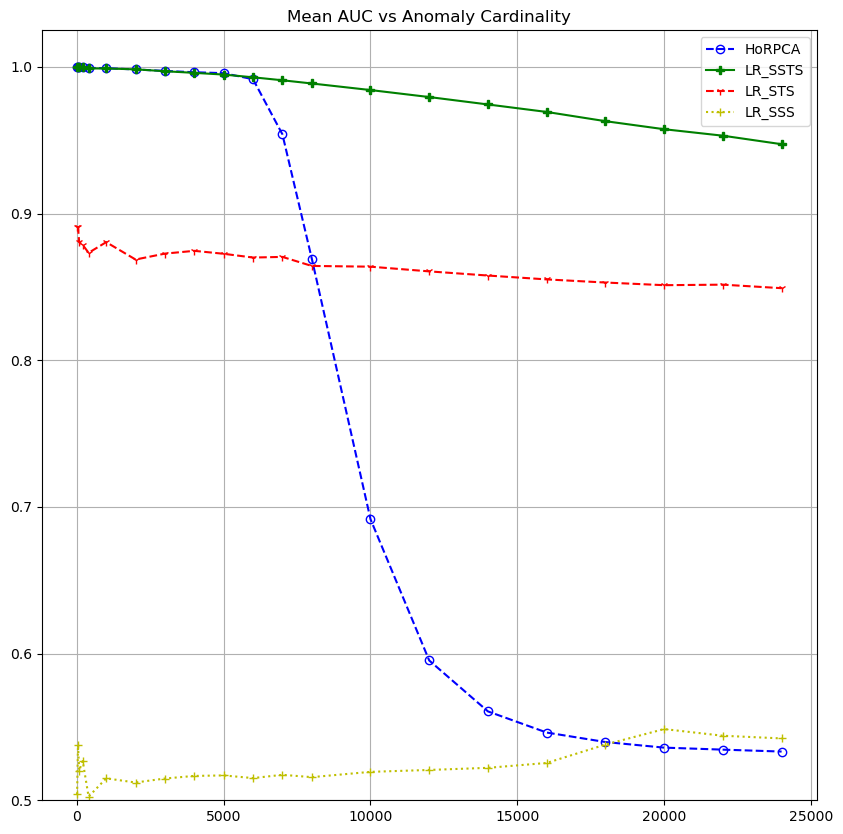

In [32]:
# display(dfm2)
fig, ax = plt.subplots(1,1, figsize=(10,10))
# dfm2.plot() /(7*24*20*40)
ax.plot(dfm_horpca['number_of_anomalies'],dfm_horpca['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
ax.plot(dfm2_lrstss['number_of_anomalies'],dfm2_lrstss['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
ax.plot(dfm2_lrsts['number_of_anomalies'],dfm2_lrsts['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
ax.plot(dfm2_lrsss['number_of_anomalies'],dfm2_lrsss['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
# ax.plot(dfm_horpca_2['anomaly_cardinality']/(7*24*20*40),dfm_horpca_2['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
# ax.plot(dfm2_lrstss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrstss_2['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
# ax.plot(dfm2_lrsts_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsts_2['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
# ax.plot(dfm2_lrsss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsss_2['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
ax.grid()
ax.set_title("Mean AUC vs Anomaly Cardinality");
ax.set_ylim([0.5,1.025]);
ax.legend()

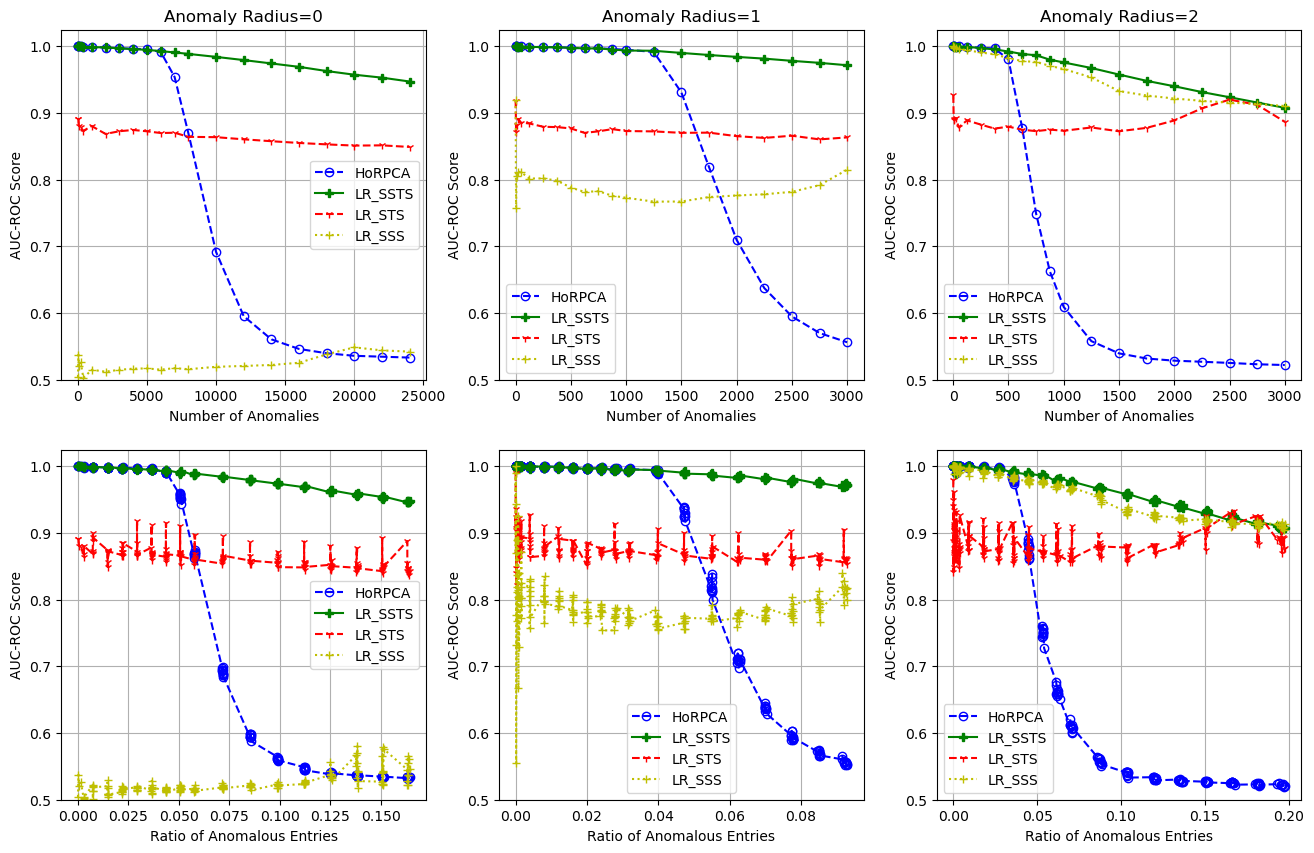

In [43]:
cwd = os.getcwd()
fig, axs = plt.subplots(2,3, figsize=(16,10))
data_names = ['exp1_rad0_2','exp1_rad1','exp1_rad2']
radiuses = ['Anomaly Radius=0', 'Anomaly Radius=1', 'Anomaly Radius=2']
for i,dn in enumerate(data_names):
    fname_lrstss = os.path.join(cwd, 'results','lrstss_'+dn+'.hdf5')
    fname_horpca = os.path.join(cwd, 'results','horpca_'+dn+'.hdf5')
    fname_lrsts = os.path.join(cwd, 'results','lrsts_'+dn+'.hdf5')
    fname_lrsss = os.path.join(cwd, 'results','lrsss_'+dn+'.hdf5')
    key = 'grid'

    with pd.HDFStore(fname_lrstss) as storedata:
        df_lrssts = storedata[key]
    with pd.HDFStore(fname_lrsts) as storedata:
        df_lrsts = storedata[key]
    with pd.HDFStore(fname_lrsss) as storedata:
        df_lrsss = storedata[key]
    with pd.HDFStore(fname_horpca) as storedata:
        df_horpca = storedata[key]
        
    dfm_lrstss = df_lrssts.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm_lrstss_2 = df_lrssts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm2_lrstss = dfm_lrstss.groupby(['number_of_anomalies'])['auc'].max().reset_index()
    dfm2_lrstss_2 = dfm_lrstss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
    # display(HTML(df_lrssts.to_html()))

    dfm_lrsts = df_lrsts.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm_lrsts_2 = df_lrsts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm2_lrsts = dfm_lrsts.groupby(['number_of_anomalies'])['auc'].max().reset_index()
    dfm2_lrsts_2 = dfm_lrsts_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
    # display(HTML(dfm2_lrsts_2.to_html()))

    dfm_lrsss = df_lrsss.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm_lrsss_2 = df_lrsss.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm2_lrsss = dfm_lrsss.groupby(['number_of_anomalies'])['auc'].max().reset_index()
    dfm2_lrsss_2 = dfm_lrsss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
    # display(HTML(dfm2_lrsss_2.to_html()))

    dfm_horpca_2 = df_horpca.groupby(['anomaly_cardinality'])[['auc','rec_err']].mean().reset_index()
    dfm_horpca = df_horpca.groupby(['number_of_anomalies'])[['auc', 'rec_err']].mean().reset_index()
    dfm_horpca_std = df_horpca.groupby(['number_of_anomalies'])[['auc', 'rec_err']].std()
    
    axs[0,i].plot(dfm_horpca['number_of_anomalies'],dfm_horpca['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
    axs[0,i].plot(dfm2_lrstss['number_of_anomalies'],dfm2_lrstss['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
    axs[0,i].plot(dfm2_lrsts['number_of_anomalies'],dfm2_lrsts['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
    axs[0,i].plot(dfm2_lrsss['number_of_anomalies'],dfm2_lrsss['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
    axs[1,i].plot(dfm_horpca_2['anomaly_cardinality']/(7*24*20*40),dfm_horpca_2['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
    axs[1,i].plot(dfm2_lrstss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrstss_2['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
    axs[1,i].plot(dfm2_lrsts_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsts_2['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
    axs[1,i].plot(dfm2_lrsss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsss_2['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
    axs[0,i].grid()
    axs[1,i].grid()
    axs[0,i].set_title(radiuses[i]);
    axs[0,i].set_ylim([0.5,1.025]);
    axs[1,i].set_ylim([0.5,1.025]);
    axs[0,i].set_xlabel('Number of Anomalies')
    axs[1,i].set_xlabel('Ratio of Anomalous Entries')
    axs[0,i].set_ylabel('AUC-ROC Score')
    axs[1,i].set_ylabel('AUC-ROC Score')
    axs[0,i].legend()
    axs[1,i].legend()

In [ ]:
client.shutdown()